# **1. Reflection**
Reflection은 에이전트가 스스로 결과를 평가·비판 한 뒤 그 피드백을 상태(state)에 기록하고, 필요하면 수정 루프로 되돌아가 답을 개선하는 설계 패턴입니다. 보통 “작성 노드(답 생성) → 리플렉션 노드(자기평가) → 라우팅(조건부 엣지)”로 구성되며, 리플렉션 노드는 품질 기준(예: 정확성, 근거, 형식)을 점수·코멘트(score, critique)로 남깁니다. 라우터는 이 정보를 읽어 임계값 미달이면 작성 노드로 되감기, 충족하면 종료 노드로 이동합니다. 무한 루프를 막기 위해 max_iters 같은 반복 한도를 두며, 툴 호출과는 별개로 LLM의 자기검토 능력을 활용해 코드 생성, 질의응답, 체인드 리저닝 등의 정확도·일관성을 높이는 데 쓰입니다.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2Fet5eoq%2FbtsQtfTBoz7%2FAAAAAAAAAAAAAAAAAAAAAM6C44vgBF-5pX8AStDskIMKM2c-gg9io9wsDgxh0NT0%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1759244399%26allow_ip%3D%26allow_referer%3D%26signature%3D9LqfZTAalr4qNMtDaaHHgd6RjCs%253D' width=600>


In [1]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [2]:
!pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.75
    Uninstalling langchain-core-0.3.75:
      Successfully uninstalled langchain-core-0.3.75


### 1-1. 가사 생성

In [3]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "당신은 5단락 노래가사를 훌륭하게 작성하는 작사 도우미입니다."
            "사용자의 요청에 따라 최고의 가사를 작성하세요."
            "사용자가 피드백을 제공할 경우, 이전 시도에서 개선된 수정본을 작성해 응답하세요.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

llm = ChatOpenAI(model="gpt-5-nano")
generate = prompt | llm

KeyboardInterrupt: 

In [ ]:
lyric = ""
request = HumanMessage(
    content="이별에 대한 가사를 작성해주세요."
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    lyric += chunk.content

### 1-2. 가사 개선

In [ ]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "당신은 가사를 채점하는 작사가입니다. 사용자가 제출한 작사에 대한 비평과 개선 사항을 작성하세요."
            "가사의 길이, 깊이, 문체 등을 포함해 구체적인 개선 요청을 제공하세요.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | llm

In [ ]:
reflection = ""
for chunk in reflect.stream({"messages": [request, HumanMessage(content=lyric)]}):
    print(chunk.content, end="")
    reflection += chunk.content

In [ ]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=lyric), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

### 1-3. Graph로 Reflection 구현

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2FKZUhB%2FbtsQxetHmFz%2FAAAAAAAAAAAAAAAAAAAAAP0EuRkgL4J0CjrSQh0IKSN45ducYKse-WsdmcfUNwRn%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1759244399%26allow_ip%3D%26allow_referer%3D%26signature%3Da5V79BTw4md0u%252FyHl1YhcHNPRpU%253D'>

In [ ]:
!pip install langgraph

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
def generation_node(state: State) -> State:
    return {"messages": [generate.invoke(state["messages"])]}

In [ ]:
def reflection_node(state: State) -> State:
    cls_map = {"ai": AIMessage, "human": HumanMessage}

    # 첫번째 사용자 요청 + 생성메시지 (reflection_node's input)
    # 첫번째 사용자 요청 + 생성메시지 + 피드백메시지 (generation_node's input)
    # 첫번째 사용자 요청 + 생성메시지 + 피드백메시지 + 수정된 생성메시지 (reflection_node's input)
    # 첫번째 사용자 요청 + 생성메시지 + 피드백메시지 + 수정된 생성메시지 + 피드백메시지 (generation_node's input)
    # ...
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]
    # translated = [state["messages"][0]] + [
    #     cls_map[msg.type](content=msg.content) for msg in state["messages"][-2:]
    # ]
    res = reflect.invoke(translated)

    return {"messages": [HumanMessage(content=res.content)]}

In [ ]:
graph_builder = StateGraph(State)
graph_builder.add_node("generate", generation_node)
graph_builder.add_node("reflect", reflection_node)
graph_builder.add_edge(START, "generate")

In [ ]:
from typing import Literal
from langgraph.graph import END

def should_continue(state: State) -> Literal["reflect", END]:
    if len(state["messages"]) > 6:
        return END
    return "reflect"


graph_builder.add_conditional_edges("generate", should_continue)

In [ ]:
graph_builder.add_edge("reflect", "generate")

In [ ]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
graph

In [ ]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
for event in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="이별에 대한 가사를 작성해주세요."
            )
        ],
    },
    config,
):
    print(event)
    print("---")

In [ ]:
state = graph.get_state(config)
state

In [ ]:
ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()

# **2. Reflextion 구현**
[“Reflexion: Language Agents with Verbal Reinforcement Learning”](https://arxiv.org/abs/2303.11366)은, 2023년 3월 20일 최초 제출, 2023년 10월 10일 v4로 개정된 논문입니다. 저자는 Noah Shinn 외 5명이고, 핵심 내용은 언어 에이전트가 스스로 언어적 피드백(반성문)을 생성·메모리에 저장해 다음 시도에 반영함으로써 성능을 높이는 프레임워크를 제안했다는 점입니다. HumanEval 등에서 유의미한 향상을 보고합니다.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2Fdzon1Q%2FbtsQxdO7zsM%2FAAAAAAAAAAAAAAAAAAAAAIv8GnJo2Z7lQar4RlJWoaap2PH03wadiph8ot4leqkE%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1759244399%26allow_ip%3D%26allow_referer%3D%26signature%3D8FwKXg927T0ByPpvHRMXDCmMW6w%253D'>

* Actor (LM): 실제 행동(답안 작성, 코드 생성 등)을 내는 언어모델입니다.
* Evaluator (LM): Actor가 낸 결과를 내부적으로 평가합니다(정확성·형식·테스트 통과 여부 판단 등).
* Self-reflection (LM): 평가 결과를 바탕으로 “다음에는 이렇게 고치자” 같은 반성문(Reflective text)을 만들어 냅니다.
* Trajectory (short-term memory): 이번 시도에서의 행동/관찰 기록(a₀, o₀, …)을 담는 단기 메모리입니다.
* Experience (long-term memory): 누적된 반성문을 쌓아두는 장기 메모리(mem)입니다. 이후 시도에서 프롬프트에 이 기억을 넣어 같은 실수를 반복하지 않게 합니다.
* Environment: 외부에서 관찰/보상(예: 유닛 테스트의 통과/실패, 웹툴의 응답 등)을 제공합니다. 외부 피드백이 있으면 Evaluator의 판단과 함께 사용됩니다.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2Fmii1M%2FbtsQzJFXs6L%2FAAAAAAAAAAAAAAAAAAAAABlDou97baB3Ry75PiiSdFP4Aml0fM58iNNa5PCw8tAm%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1759244399%26allow_ip%3D%26allow_referer%3D%26signature%3D4AJfc3vS%252BrrpVpN%252BWzMG7%252BP%252FfxE%253D'>

In [ ]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-5-nano")

In [ ]:
!pip install langchain_community

In [ ]:
!pip install langchain-tavily

In [ ]:
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(max_results=5)

### 2-1. 필요한 데이터 클래스 정의
Reflection - 놓친것 / 불필요한 것

In [ ]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel, Field

class Reflection(BaseModel):
    missing: str = Field(description="누락되거나 부족한 부분에 대한 비평")
    superfluous: str = Field(description="불필요한 부분에 대한 비평")

In [ ]:
# AnswerQuestion - 답변 / 답변에 대한 반성 / 개선하기 위한 검색 쿼리
class AnswerQuestion(BaseModel):
    answer: str = Field(description="질문에 대한 10문장 이내의 자세한 답변")
    search_queries: list[str] = Field(
        description="현재 답변에 대한 비평을 해결하기 위한 추가 조사를 위한 1~3개의 웹 검색 쿼리"
    )
    reflection: Reflection = Field(description="답변에 대한 자기반성 내용")

In [ ]:
# Responder - 구조화된 출력을 위한 답변기
class Responder:
    def __init__(self, runnable):
        self.runnable = runnable # Chain

    def respond(self, state: dict):
        response = self.runnable.invoke(
            {"messages": state["messages"]}
        )
        return {"messages": response}

### 2-2. 초기 답변기 만들기 (Initial responder)
초기 답변을 위한 Chain 생성 -출력 스키마를 도구로 사용

In [ ]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """당신은 전문 연구자입니다.

            1. {first_instruction}
            2. <Reflect> 생성한 답변을 다시 되돌아보고 개선할 수 있도록 비판하세요.
            3. <Recommend search queries> 답변의 질을 높이기 위해 추가적으로 조사해야 할 정보에 대한 웹 검색 쿼리를 추천하세요.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<Reflect> 사용자 원래 질문과 지금까지의 행동을 되돌아보세요."
        ),
    ]
)

initial_answer_chain = actor_prompt_template.partial(
    first_instruction="질문에 대한 10문장 이내의 자세한 답변을 제공해주세요.", # 초기 답변
) | llm.bind_tools(tools=[AnswerQuestion], tool_choice="any")

* [구조화 출력을 위해 스키마를 도구로 사용하는 방법](https://python.langchain.com/docs/concepts/structured_outputs/#using-tool-calling)

In [ ]:
llm_with_tool = llm.bind_tools(tools=[AnswerQuestion], tool_choice="any")
response = llm_with_tool.invoke([HumanMessage(content="AI Agent가 무엇인가요?")])
print(response)

In [ ]:
response.tool_calls[0]['args']

In [ ]:
first_responder = Responder(runnable=initial_answer_chain)
first_responder

In [ ]:
example_question = "AI Agent가 무엇인가요?"
initial = first_responder.respond(
    {"messages": [HumanMessage(content=example_question)]}
)

initial

In [ ]:
# tool 호출 결과 확인 (AnswerQuestion 에 맞춰 출력 생성)
initial["messages"].tool_calls[0]["args"]

### 2-3. 수정 단계(Revision)

In [ ]:
class ReviseAnswer(AnswerQuestion):
    # 답변 > 반성 > 근거 인용 > 검색 제안
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="업데이트된 답변에 사용된 인용 출처"
    )

In [ ]:
revise_instructions = """이전 답변을 새로운 정보를 바탕으로 수정하세요.
- 이전 비평 내용을 활용해 중요한 정보를 추가해야 합니다.
  - 수정된 답변에는 반드시 숫자로 된 인용 표시를 포함하여 검증 가능하도록 해야 합니다.
  - 답변 하단에 "참고문헌" 섹션을 추가하세요 (이 부분은 단어 수 제한에 포함되지 않습니다). 형식은 다음과 같습니다:
    - [1] https://example.com
    - [2] https://example.com

- 이전 비평 내용을 바탕으로 불필요한 정보를 제거하고, 최종 답변은 반드시 200자를 넘지 않도록 하세요.
"""

revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
) | llm.bind_tools(tools=[ReviseAnswer], tool_choice="any")

revisor = Responder(runnable=revision_chain)
revisor

In [ ]:
# 초기답변에서 생성한 웹검색 쿼리를 Tool 실행한 결과를 함께 입력

import json

revised = revisor.respond(
    {
        "messages": [
            HumanMessage(content=example_question),
            initial["messages"],
            ToolMessage(
                tool_call_id=initial['messages'].additional_kwargs['tool_calls'][0]['id'],
                content=json.dumps(
                    tavily_tool.invoke(
                        {
                            "query": initial["messages"].tool_calls[0]["args"]['search_queries'][0]
                        }
                    )
                ),
            ),
        ]
    }
)

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2FnMKU1%2FbtsQwRziUZl%2FAAAAAAAAAAAAAAAAAAAAAASlhE2QFrMfwp2mVpfbJqW1PV9_JrnKxfrPSLouN6QH%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1759244399%26allow_ip%3D%26allow_referer%3D%26signature%3Dmo7gpz9i5fHpvBdpj4E4qkNltG4%253D'>

In [ ]:
revised["messages"]

In [ ]:
revised["messages"].tool_calls

### 2.4. 웹검색을 위한 툴 노드 생성

In [ ]:
tavily_tool.batch(
    [
        {"query": initial["messages"].tool_calls[0]["args"]['search_queries'][0]}
    ]
)

In [ ]:
from langchain_core.tools import StructuredTool
from langgraph.prebuilt import ToolNode

def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

### 2-5. 그래프 생성하기

In [ ]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
MAX_ITERATIONS = 5
graph_builder = StateGraph(State)
graph_builder.add_node("draft", first_responder.respond)

graph_builder.add_node("execute_tools", tool_node) # 웹 검색 진행
graph_builder.add_node("revise", revisor.respond)

graph_builder.add_edge("draft", "execute_tools")
graph_builder.add_edge("execute_tools", "revise")

In [ ]:
def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i

def event_loop(state: list):
    num_iterations = _get_num_iterations(state["messages"])
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"

In [ ]:
graph_builder.add_conditional_edges("revise", event_loop, ["execute_tools", END])
graph_builder.add_edge(START, "draft")
graph = graph_builder.compile()
graph

In [ ]:
events = graph.stream(
    {"messages": [HumanMessage(content="AI Agent가 무엇인가요?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()

# **3. Plan & Execute**

In [ ]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [ ]:
!pip install langchain_community

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [ ]:
search_tool = TavilySearchResults(max_results=3)
tools = [search_tool]

In [ ]:
!pip install langchain_openai

In [ ]:
!pip install langgraph

In [ ]:
# ReAct 패턴
# 추론 -> 행동 -> 관찰 -> 답변,  자동으로 생성
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-5-nano")
prompt = "You are a helpful assistant."
plan_executor = create_react_agent(llm, tools, prompt=prompt)
plan_executor

In [ ]:
plan_executor.invoke({'messages': [('user', '2025년 한국의 최저시급은 얼마입니까?')]})

In [ ]:
from pydantic import BaseModel, Field
from typing import List

In [ ]:
class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage

In [ ]:
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
            This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
            The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
planner = planner_prompt | llm.with_structured_output(Plan)

In [ ]:
plan_result = planner.invoke(
    {
        "messages": [HumanMessage(
            content="2025년 한국에서 개봉한 영화 중 가장 흥행한 영화는 무엇인가요?",
        )]
    }
)

plan_result

In [ ]:
plan_result.steps

In [ ]:
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
    This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

    Your objective was this:
    {input}

    Your original plan was this:
    {plan}

    You have currently done the follow steps:
    {past_steps}

    Update your plan accordingly.
    If no more steps are needed and you can return to the user, then respond with that.
    Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done.
    Do not return previously done steps as part of the plan."""
)

In [ ]:
from typing import Union

class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

In [ ]:
replanner = replanner_prompt | llm.with_structured_output(Act)

In [ ]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [ ]:
# 계획 생성
def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}

In [ ]:
# 계획 실행
def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))

    task = plan[0]
    task_formatted = f"""For the following plan:
    {plan_str}\n\nYou are tasked with executing step {1}, {task}."""

    agent_response = plan_executor.invoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)], # 실행 완료한 계획과 결과 저장
    }

In [ ]:
# 계획 수정
def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    if isinstance(output.action, Response): # 답변이 바로 가능한 상태
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}

In [ ]:
from langgraph.graph import END

def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [ ]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(PlanExecute)


graph_builder.add_node("planner", plan_step)
graph_builder.add_node("agent", execute_step)
graph_builder.add_node("replan", replan_step)

graph_builder.add_edge(START, "planner")

graph_builder.add_edge("planner", "agent")
graph_builder.add_edge("agent", "replan")

graph_builder.add_conditional_edges(
    "replan",
    should_end,
    ["agent", END],
)

graph = graph_builder.compile()

In [ ]:
graph

In [ ]:
config = {'recursion_limit': 50}
inputs = {'input': '2024년 노벨문학상 수상자의 출신국가는 어디인가요?'}
for event in graph.stream(inputs, config=config, stream_mode='values'):
    for k, v in event.items():
        print(k, v)
    print('*' * 50)

# **4. 코드 수정을 반복하는 데이터 전처리 Agent**

### 클로드
클로드(Claude)는 앤트로픽(Anthropic)에서 개발한 대규모 언어 모델(LLM) 기반의 인공지능 챗봇으로, 사람과의 대화, 글쓰기, 요약, 코드 작성 등 다양한 작업을 수행할 수 있는 생성형 AI입니다. 이름은 인공지능의 선구자 클로드 섀넌(Claude Shannon)에서 따왔으며, “헌宪법 기반 AI(constitutional AI)” 접근법을 적용해 안전성과 투명성을 강화한 것이 특징입니다. 즉, 인간의 직접적인 지시보다는 미리 정해둔 원칙과 가이드라인을 통해 스스로 출력을 조율하도록 설계되었기 때문에, 사용자가 안심하고 활용할 수 있는 대화형 AI라는 점에서 주목받고 있습니다.

In [1]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("ANTHROPIC_API_KEY")

OPENAI_API_KEY: ··········
ANTHROPIC_API_KEY: ··········


In [2]:
from langchain_core.tools import tool
import pandas as pd

In [3]:
@tool
def describe_data(csv: str) -> str:
    """Describe the date column in the dataframe.

    Args:
        csv: csv data path string
    """
    df = pd.read_csv(csv)
    describe_str = f"""Data: {csv}""" + df.describe(include='all').to_string()
    return describe_str

In [4]:
tools = [describe_data]

In [5]:
!pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.75
    Uninstalling langchain-core-0.3.75:
      Successfully uninstalled langchain-core-0.3.75


In [6]:
!pip install langchain_anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 kB 5.7 MB/s eta 0:00:00


In [7]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

llm_gpt = ChatOpenAI(model="gpt-5-nano")
llm_with_tools = llm_gpt.bind_tools(tools, tool_choice="any")

In [8]:
response = llm_with_tools.invoke(
    "https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv 이 데이터의 전처리를 해주세요."
)

In [9]:
response.tool_calls[0]

{'name': 'describe_data',
 'args': {'csv': 'https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv'},
 'id': 'call_VLcYSy8dVc9G9Wwyt4rsOPfC',
 'type': 'tool_call'}

In [10]:
response.tool_calls[0]['args']

{'csv': 'https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv'}

In [11]:
from pydantic import BaseModel, Field

class code(BaseModel):
    """Schema for code solutions."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

In [12]:
from langchain_core.prompts import ChatPromptTemplate

GENERATE_CODE_TEMPLATE = """
Given the following pandas `describe()` output of a dataset,

write a **directly executable Python code** to:
1. handle missing values,
2. convert categorical columns,
3. ...any additional preprocessing needed,
4. prepare the dataset for machine learning.

Here is the describe result of the dataset:
\n ------- \n  {context} \n ------- \n

Do not wrap the code in a function and the response in any backticks or anything else. The code should be written as a flat script, so that it can be run immediately and any errors will be visible during execution.
Ensure any code you provide can be executed \n
with all required imports and variables defined. Structure your answer with a description of the code solution. \n
Then list the imports. And finally list the functioning code block.
"""

code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        ("user", GENERATE_CODE_TEMPLATE),
    ]
)

In [13]:
from langchain_anthropic import ChatAnthropic

llm_claude= ChatAnthropic(model="claude-sonnet-4-20250514")

In [14]:
response.tool_calls[0]['args']

{'csv': 'https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv'}

In [15]:
tool_result = describe_data.invoke(response.tool_calls[0]['args'])
print(tool_result)

Data: https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv       Number of times pregnant  Plasma glucose concentration a 2 hours in an oral glucose tolerance test  Diastolic blood pressure (mm Hg)  Triceps skin fold thickness (mm)  2-Hour serum insulin (mu U/ml)  Body mass index (weight in kg/(height in m)^2)  Diabetes pedigree function  Age (years)  Class variable
count                768.000000                                                                768.000000                        768.000000                        768.000000                      768.000000                                      768.000000                  768.000000   768.000000      768.000000
mean                   3.845052                                                                120.894531                         69.105469                         20.536458                       79.799479                                       31.992578                    0.471876    33.240885

In [16]:
generated_code = llm_claude.invoke(
    code_gen_prompt.format_messages(context=tool_result)
)
print("generated_code", generated_code)

generated_code content='## Description\n\nThis code will preprocess the diabetes dataset for machine learning by:\n1. Loading the data from the provided URL\n2. Handling missing values that are encoded as zeros (common in medical datasets)\n3. Applying appropriate imputation strategies for different types of features\n4. Scaling numerical features for better model performance\n5. Splitting the data into training and testing sets\n\nThe dataset appears to have missing values encoded as zeros for several medical measurements (glucose, blood pressure, skin fold thickness, insulin, BMI), which need to be properly handled as true missing values and imputed.\n\n## Imports\n\n```python\nimport pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.impute import SimpleImputer\n```\n\n## Code\n\n```python\nimport pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\n

In [17]:
code_structurer = llm_gpt.with_structured_output(code)
code_solution = code_structurer.invoke(generated_code.content)
print("code_solution", code_solution)

code_solution prefix="Preprocess the diabetes dataset by loading it from the provided URL, treating medically implausible zeros as missing values, imputing missing values, scaling numerical features, and splitting into train/test sets. The dataset may use different target column names (e.g., 'Outcome' or 'Class variable'), so the code detects the target column robustly. Only the medically invalid zeros in Glucose, BloodPressure, SkinThickness, Insulin, and BMI are replaced with NaN before imputation." imports='import pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.impute import SimpleImputer' code='# Load the dataset\nurl = "https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv"\ndf = pd.read_csv(url)\n\n# Detect target column robustly\nif \'Outcome\' in df.columns:\n    target_col = \'Outcome\'\nelif \'Class variable\' in df.columns:\n    target_col = \'Class

In [18]:
print(code_solution.imports)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [19]:
print(code_solution.code)

# Load the dataset
url = "https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv"
df = pd.read_csv(url)

# Detect target column robustly
if 'Outcome' in df.columns:
    target_col = 'Outcome'
elif 'Class variable' in df.columns:
    target_col = 'Class variable'
else:
    raise ValueError("Target column not found. Expected 'Outcome' or 'Class variable'.")

y = df[target_col]
X = df.drop(columns=[target_col])

# Identify columns where zeros are considered missing (medical context)
zero_as_missing_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# Replace zeros with NaN for these columns when present
for col in zero_as_missing_cols:
    if col in X.columns:
        X[col] = X[col].replace(0, np.nan)

print("Missing values per column before imputation:")
print(X.isnull().sum().sort_values(ascending=False))

# Impute missing values (median is robust to outliers) for numeric features
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFra

In [20]:
!pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 12.2 MB/s eta 0:00:00


In [21]:
from langgraph.graph import StateGraph, MessagesState

class State(MessagesState): # messages
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        context: Data summary
        generation : Code solution
        iterations : Number of tries
    """
    error: str # yes or no
    context: str
    generation: str
    iterations: int

graph_builder = StateGraph(State)

In [22]:
from langchain_core.tools import tool
import pandas as pd

@tool
def describe_data(csv: str) -> str:
    """Describe the date column in the dataframe.

    Args:
        csv: csv data path string
    """
    df = pd.read_csv(csv)
    describe_str = f"""Data: {csv}""" + df.describe(include='all').to_string()
    return describe_str

In [23]:
llm_with_tools = llm_gpt.bind_tools(tools=[describe_data], tool_choice="any")

In [24]:
def chatbot(state: State):
    print("##### HI ! #####")
    response = llm_with_tools.invoke(state["messages"])
    print("첫번째 LLM 호출 결과 : ", response)
    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot)

In [25]:
def add_context(state: State):
    print("##### ADD CONTEXT #####")
    if messages := state.get("messages", []):
        message = messages[-1] # 마지막 message
    else:
        raise ValueError("No message found in input")

    for tool_call in message.tool_calls:
        for tool in tools:
            if tool.name == tool_call['name']:
                describe_str = tool.invoke(tool_call['args'])

    # Get context from describe_data tool
    print("데이터 통계 (context) : ", describe_str[:100])
    return {"context": describe_str}

graph_builder.add_node("add_context", add_context)

In [26]:
from langgraph.graph import END

def guardrail_route(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "add_context"
    return END


graph_builder.add_conditional_edges(
    "chatbot",
    guardrail_route,
    {"add_context": "add_context", END: END},
)

In [27]:
from pydantic import BaseModel, Field

class code(BaseModel):
    """Schema for code solutions."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

In [28]:
from langchain_core.prompts import ChatPromptTemplate

GENERATE_CODE_TEMPLATE = """
Given the following pandas `describe()` output of a dataset,

write a **directly executable Python code** to:
1. handle missing values,
2. convert categorical columns,
3. ...any additional preprocessing needed,
4. prepare the dataset for machine learning.

Here is the describe result of the dataset:
\n ------- \n  {context} \n ------- \n

Do not wrap the code in a function and the response in any backticks or anything else. The code should be written as a flat script, so that it can be run immediately and any errors will be visible during execution.
Ensure any code you provide can be executed \n
with all required imports and variables defined. Structure your answer with a description of the code solution. \n
Then list the imports. And finally list the functioning code block.
"""

code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        ("user", GENERATE_CODE_TEMPLATE),
    ]
)

In [29]:
def generate(state: State):
    print("##### GENERATING CODE SOLUTION #####")

    context = state["context"]

    generated_code = llm_claude.invoke(
        code_gen_prompt.format_messages(context=context)
    )
    code_structurer = llm_gpt.with_structured_output(code)
    code_solution = code_structurer.invoke(generated_code.content)

    messages = [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    return {"generation": code_solution, "messages": messages}

graph_builder.add_node("generate", generate)

In [30]:
def code_check(state: State):
    print("##### CHECKING CODE #####")

    code_solution = state["generation"]

    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        print("에러 메시지 : ", error_message)
        return {
            "generation": code_solution,
            "messages": error_message,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        print("에러 메시지 : ", error_message)
        return {
            "generation": code_solution,
            "messages": error_message,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "error": "no",
    }

graph_builder.add_node("code_check", code_check)

In [31]:
from langchain_core.prompts import ChatPromptTemplate

reflect_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are given an error message that occurred while running a Python script, along with the original code that produced the error.
            Provide a corrected version of the original code that resolves the issue.
            Ensure the code runs without errors and maintains the intended functionality."""
        ),
        (
            "user",
            """
            --- ERROR MESSAGE ---
            {error}
            --- ORIGINAL CODE ---
            {code_solution}
            ----------------------

            Ensure any code you provide can be executed \n
            with all required imports and variables defined. Structure your answer with a description of the code solution. \n
            Then list the imports. And finally list the functioning code block.""",
        )
    ]
)

In [32]:
def reflect(state: State):
    print("---REFLECTING CODE SOLUTION---")

    error = state["messages"][-1].content
    code_solution = state["generation"]
    code_solution = f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}"

    corrected_code = llm_claude.invoke(reflect_prompt.format_messages(error=error, code_solution=code_solution))
    code_structurer = llm_gpt.with_structured_output(code)
    reflections = code_structurer.invoke(corrected_code.content)
    print("수정된 코드 : ", reflections)

    messages = [
        (
            "assistant",
            f"{reflections.prefix} \n Imports: {reflections.imports} \n Code: {reflections.code}",
        )
    ]

    return {"generation": reflections, "messages": messages, "iterations": state["iterations"] + 1}

graph_builder.add_node("reflect", reflect)

In [33]:
max_iterations = 5

In [34]:
def decide_to_finish(state: State):
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations: # 에러가 없거나 max_iterations에 도달하면 종료
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "reflect"

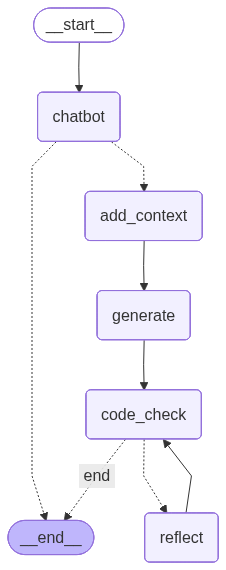

In [35]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("add_context", "generate")
graph_builder.add_edge("generate", "code_check")
graph_builder.add_conditional_edges(
    "code_check",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect"
    },
)
graph_builder.add_edge("reflect", "code_check")

graph = graph_builder.compile()
graph

In [36]:
question = 'titanic.csv 데이터의 전처리를 부탁해요~'

In [37]:
solution = graph.invoke({"messages": [('user', question)], 'iterations': 0, 'error': ''})

##### HI ! #####
첫번째 LLM 호출 결과 :  content='' additional_kwargs={'tool_calls': [{'id': 'call_82Jcpo1aDVM3eaZldLQnluXv', 'function': {'arguments': '{"csv":"titanic.csv"}', 'name': 'describe_data'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 282, 'prompt_tokens': 148, 'total_tokens': 430, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 256, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CGExd3sG5Ia70S9H89R5sxzhO8gvI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--ffc1533e-6677-40ca-b29f-d8cfe577f362-0' tool_calls=[{'name': 'describe_data', 'args': {'csv': 'titanic.csv'}, 'id': 'call_82Jcpo1aDVM3eaZldLQnluXv', 'type': 'tool_call'}] usage_metadata={'input_tokens': 148, 'output_tokens': 282, 'total_tokens': 430, 'i

<string>:28: SyntaxWarning: invalid escape sequence '\.'
<string>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<string>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=Tru

In [38]:
print(solution["generation"].prefix,"\n")
print(solution["generation"].imports,"\n")
print(solution["generation"].code)

You're seeing an unexpected indent error likely due to inconsistent indentation and an incomplete code block. Below is a cleaned, complete Titanic preprocessing pipeline with consistent 4-space indentation and a working baseline logistic regression model. 

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

# Load the dataset
df = pd.read_csv('titanic.csv')

print("Original dataset shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())

# Handle missing values
# Age: Fill with median
df['Age'].fillna(df['Age'].median(), inplace=True)

# Embarked: Fill with mode (most frequent value)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Cabin: Create a binary feature for cabin availability and drop original
df['Has_Cabin']